In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

In [2]:
meg = pd.read_csv('Meg Price History - Hoja 1.csv')
pta = pd.read_csv('PTA Price History - Hoja 1.csv')

##### Análisis de la información y limpieza

In [3]:
meg.head()

,Fecha,MEG c/lb
0,2/03/2018 0:00:00,"54,34"
1,9/03/2018 0:00:00,"54,34"
2,16/03/2018 0:00:00,"54,34"
3,23/03/2018 0:00:00,"54,34"
4,29/03/2018 0:00:00,"52,84"


In [4]:
pta.head()

,Fecha,PTA c/lb
0,2/03/2018 0:00:00,"48,18"
1,9/03/2018 0:00:00,"48,18"
2,16/03/2018 0:00:00,"48,18"
3,23/03/2018 0:00:00,"48,18"
4,29/03/2018 0:00:00,"48,01"


In [5]:
meg['Fecha']= meg['Fecha'].str.replace('/', '-')

In [6]:
pta['Fecha']= pta['Fecha'].str.replace('/', '-')

In [7]:
meg['MEG c/lb']= meg['MEG c/lb'].str.replace(',', '.')

In [8]:
pta['PTA c/lb']= pta['PTA c/lb'].str.replace(',', '.')

In [9]:
meg['MEG c/lb'] = meg['MEG c/lb'].astype('float64')

In [10]:
pta['PTA c/lb'] = pta['PTA c/lb'].astype('float64')

In [11]:
meg['Fecha'] = pd.to_datetime(meg['Fecha'])

In [12]:
pta['Fecha'] = pd.to_datetime(pta['Fecha'])

In [13]:
pta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Fecha     237 non-null    datetime64[ns]
 1   PTA c/lb  237 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.8 KB


In [14]:
meg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Fecha     237 non-null    datetime64[ns]
 1   MEG c/lb  237 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.8 KB


In [15]:
meg = meg.set_index('Fecha')

In [16]:
pta = pta.set_index('Fecha')

In [17]:
meg.head()

,MEG c/lb
Fecha,
2018-02-03,54.34
2018-09-03,54.34
2018-03-16,54.34
2018-03-23,54.34
2018-03-29,52.84


In [18]:
pta.head()

,PTA c/lb
Fecha,
2018-02-03,48.18
2018-09-03,48.18
2018-03-16,48.18
2018-03-23,48.18
2018-03-29,48.01


In [19]:
pta.tail()

,PTA c/lb
Fecha,
2022-10-28,71.0
2022-04-11,69.0
2022-11-11,69.0
2022-11-18,69.0
2022-11-25,69.0


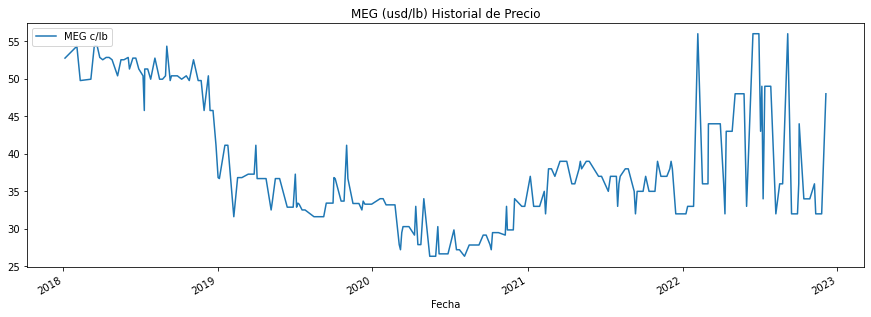

In [20]:
meg.plot(figsize=(15, 5),title='MEG (usd/lb) Historial de Precio')
plt.show()

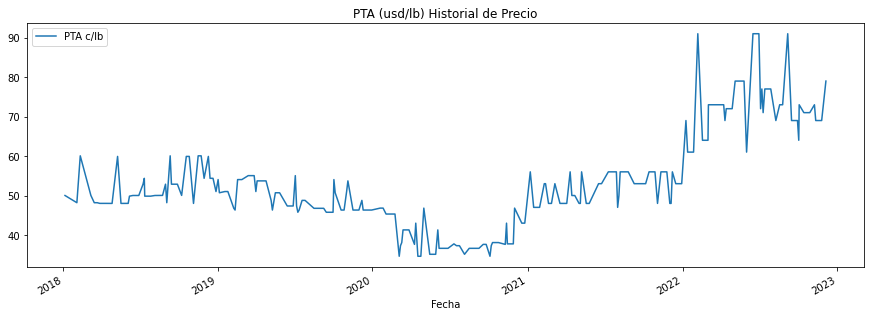

In [21]:
pta.plot(figsize=(15, 5),title='PTA (usd/lb) Historial de Precio')
plt.show()

In [22]:
meg1=meg.copy()

In [23]:
pta1=pta.copy()

##### Entrenamiento de los datos

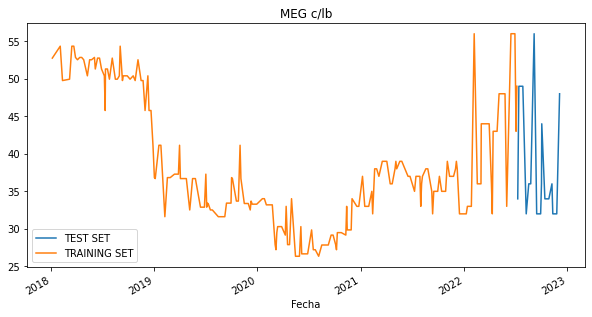

In [24]:
split_date = '7-Jul-2022'
meg1_train = meg1.loc[pta1.index <= split_date].copy()
meg1_test = meg1.loc[pta1.index > split_date].copy()

# Plot train and test so you can see where we have split
meg1_test \
    .rename(columns={'MEG c/lb': 'TEST SET'}) \
    .join(meg1_train.rename(columns={'MEG c/lb': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='MEG c/lb', ms=1)
plt.show()

In [25]:
meg1_train_prophet = meg1_train.reset_index() \
    .rename(columns={'Fecha':'ds',
                     'MEG c/lb':'y'})

In [26]:
meg1_train_prophet

,ds,y
0,2018-02-03,54.34
1,2018-09-03,54.34
2,2018-03-16,54.34
3,2018-03-23,54.34
4,2018-03-29,52.84
...,...,...
211,2022-06-30,56.00
212,2022-07-07,49.00
213,2022-04-08,36.00
214,2022-01-09,32.00


In [27]:
model = Prophet()
model.fit(meg1_train_prophet)

18:39:13 - cmdstanpy - INFO - Chain [1] start processing
18:39:14 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
meg1_test_prophet = meg1_test.reset_index() \
    .rename(columns={'Fecha':'ds',
                     'MEG c/lb':'y'})

meg1_test_fcst = model.predict(meg1_test_prophet)

In [29]:
meg1_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-07-10,43.236931,39.263825,48.931910,43.236931,43.236931,0.999770,0.999770,0.999770,0.770770,0.770770,0.770770,0.228999,0.228999,0.228999,0.0,0.0,0.0,44.236700
1,2022-07-14,43.314233,38.016097,47.376617,43.312816,43.314233,-0.531636,-0.531636,-0.531636,-0.069605,-0.069605,-0.069605,-0.462031,-0.462031,-0.462031,0.0,0.0,0.0,42.782597
2,2022-07-21,43.449511,37.460733,46.808325,43.436237,43.457236,-1.199515,-1.199515,-1.199515,-0.069605,-0.069605,-0.069605,-1.129910,-1.129910,-1.129910,0.0,0.0,0.0,42.249996
3,2022-07-28,43.584790,38.229802,47.099855,43.559309,43.604411,-1.128265,-1.128265,-1.128265,-0.069605,-0.069605,-0.069605,-1.058660,-1.058660,-1.058660,0.0,0.0,0.0,42.456525
4,2022-08-09,43.816696,38.460795,47.816907,43.777877,43.852878,-0.861682,-0.861682,-0.861682,-0.549594,-0.549594,-0.549594,-0.312087,-0.312087,-0.312087,0.0,0.0,0.0,42.955014


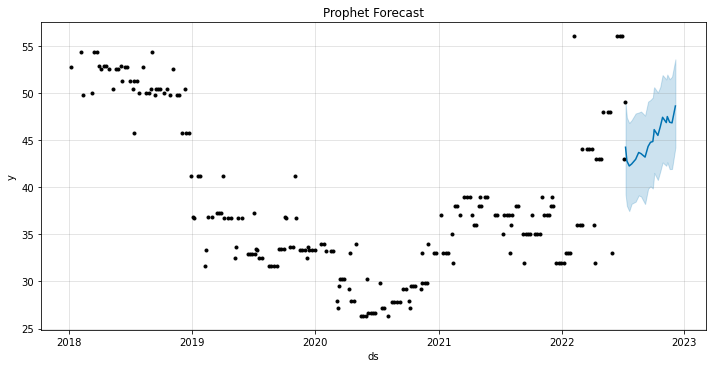

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(meg1_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

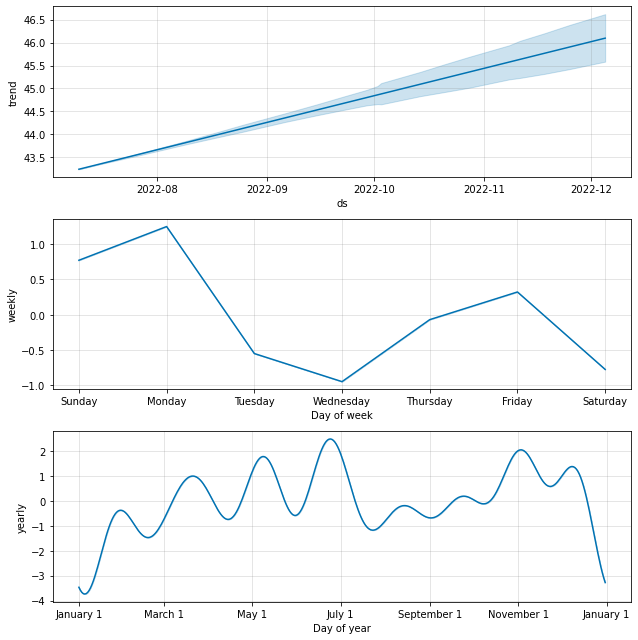

In [31]:
fig = model.plot_components(meg1_test_fcst)
plt.show()

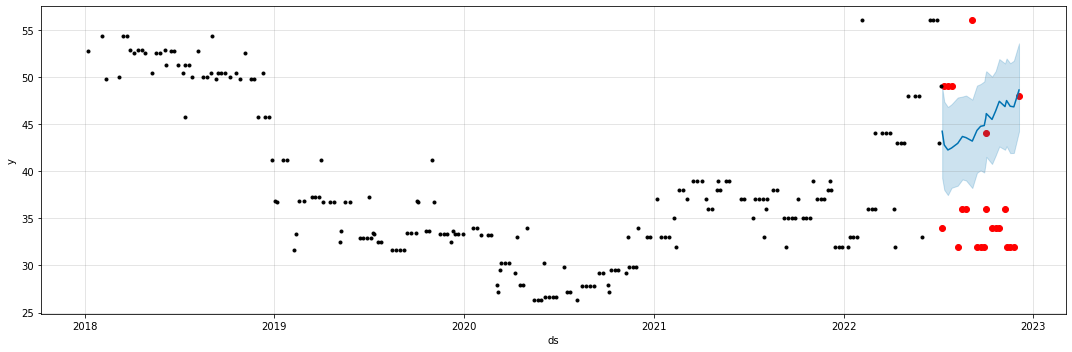

In [32]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(meg1_test.index, meg1_test['MEG c/lb'], color='r')
fig = model.plot(meg1_test_fcst, ax=ax)

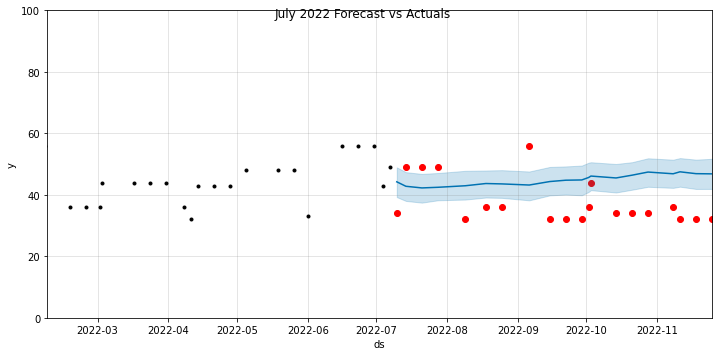

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(meg1_test.index, meg1_test['MEG c/lb'], color='r')
fig = model.plot(meg1_test_fcst, ax=ax)
ax.set_xbound(lower='02-07-2022',
              upper='25-11-2022')
ax.set_ylim(0, 100)
plot = plt.suptitle('July 2022 Forecast vs Actuals')

In [34]:
np.sqrt(mean_squared_error(y_true=meg1_test['MEG c/lb'],
                   y_pred=meg1_test_fcst['yhat']))

11.356772199333141

In [35]:
mean_absolute_error(y_true=meg1_test['MEG c/lb'],
                   y_pred=meg1_test_fcst['yhat'])

10.590495199629355

In [36]:
# Calculates MAPE given y_true and y_pred
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [37]:
mean_absolute_percentage_error(y_true=meg1_test['MEG c/lb'],
                   y_pred=meg1_test_fcst['yhat'])

30.035151003234013

In [38]:
future = model.make_future_dataframe(periods=365, include_history=False)

In [39]:
forecast_meg = model.predict(future)

In [40]:
forecast_meg.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
360,2023-07-03,50.155462,47.908372,57.948834,48.337911,52.024902,2.885438,2.885438,2.885438,1.248136,1.248136,1.248136,1.637302,1.637302,1.637302,0.0,0.0,0.0,53.040899
361,2023-07-04,50.174787,46.396048,56.080710,48.344513,52.053103,0.907631,0.907631,0.907631,-0.549594,-0.549594,-0.549594,1.457226,1.457226,1.457226,0.0,0.0,0.0,51.082419
362,2023-07-05,50.194113,45.199138,55.568309,48.351561,52.081303,0.320604,0.320604,0.320604,-0.947410,-0.947410,-0.947410,1.268014,1.268014,1.268014,0.0,0.0,0.0,50.514717
363,2023-07-06,50.213438,46.159009,56.513282,48.359264,52.109503,1.002706,1.002706,1.002706,-0.069605,-0.069605,-0.069605,1.072311,1.072311,1.072311,0.0,0.0,0.0,51.216144
364,2023-07-07,50.232764,46.051955,56.117384,48.372204,52.137205,1.194851,1.194851,1.194851,0.322079,0.322079,0.322079,0.872773,0.872773,0.872773,0.0,0.0,0.0,51.427615


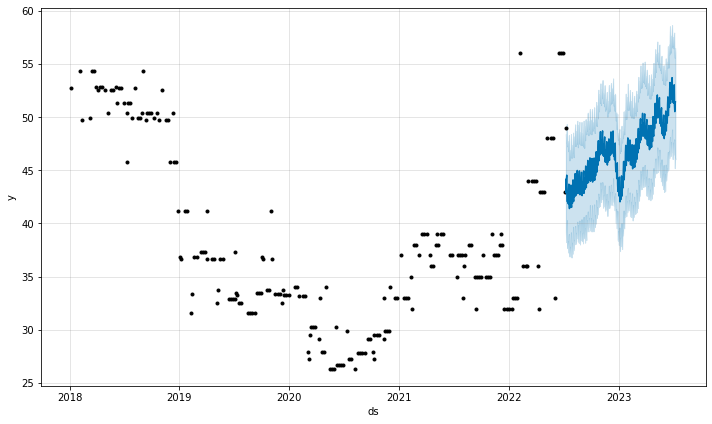

In [41]:
fig1 = model.plot(forecast_meg)

In [42]:
filename = 'forecast_meg.csv'
forecast_meg.to_csv(filename,index=False)
print('Saved file: ' + filename)

Saved file: forecast_meg.csv
